No GPU found. Using CPU.
Dataset (10%) prepared successfully!
Found 321 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


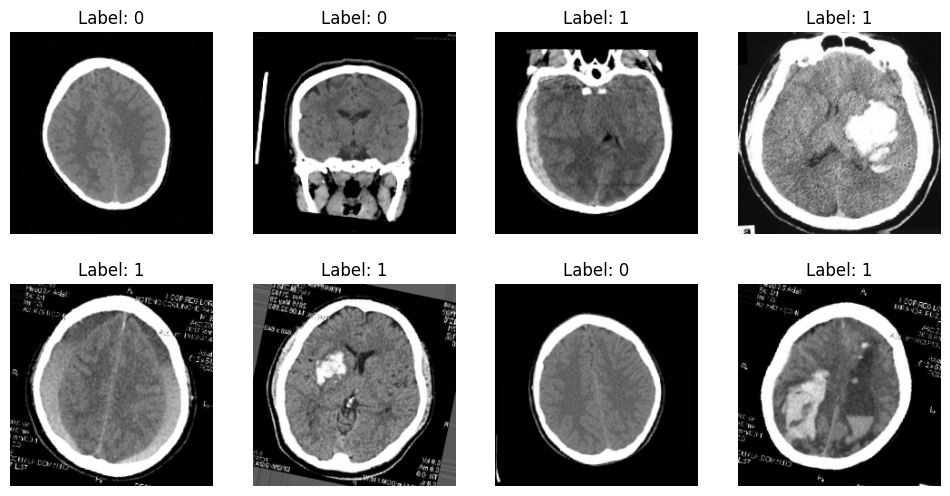

e:\01_Personal Gigs\00_Repository\06_CT_Analysis\AI-Images_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN Model...


e:\01_Personal Gigs\00_Repository\06_CT_Analysis\AI-Images_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil

# GPU Utilization
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU available: {physical_devices[0]}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Paths and Parameters
dataset_path = "./CT/Brain Tumor CT scan Images"
train_dir = "./data03/train"
val_dir = "./data03/val"
test_dir = "./data03/test"
image_size = (224, 224)
batch_size = 32
epochs = 10
random_seed = 42

# Prepare Dataset with 10% Subset
def prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir, val_split=0.2, test_split=0.1):
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for label in ["Healthy", "Tumor"]:
        img_dir = os.path.join(dataset_path, label)
        images = os.listdir(img_dir)
        images = [os.path.join(img_dir, img) for img in images]

        # Select 10% of the data
        subset_images = np.random.choice(images, int(len(images) * 0.1), replace=False)

        train_images, temp_images = train_test_split(subset_images, test_size=(val_split + test_split), random_state=random_seed)
        val_images, test_images = train_test_split(temp_images, test_size=test_split / (val_split + test_split), random_state=random_seed)

        # Copy images to respective directories
        for img in train_images:
            dest = os.path.join(train_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in val_images:
            dest = os.path.join(val_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in test_images:
            dest = os.path.join(test_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

    print("Dataset (10%) prepared successfully!")

# Data Generators
def create_generators(train_dir, val_dir, test_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, horizontal_flip=True, rotation_range=15)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
    )

    return train_generator, val_generator, test_generator

# Build CNN Model
def build_cnn_model(input_shape, dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build Pre-trained Models
def build_pretrained_model(base_model, input_shape, dropout_rate=0.5):
    base_model = base_model(include_top=False, weights="imagenet", input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Train and Evaluate Model
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(f"{model_name}.keras", monitor="val_accuracy", save_best_only=True, mode="max")
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Evaluate on Test Data
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return test_accuracy, history

# Main Execution
if __name__ == "__main__":
    prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir)
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir, image_size, batch_size)

    # Visualize Data
    sample_images, sample_labels = next(train_gen)
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Label: {int(sample_labels[i])}")
        plt.axis("off")
    plt.show()

    input_shape = image_size + (3,)

    # Build Models
    cnn_model = build_cnn_model(input_shape)
    vgg16_model = build_pretrained_model(VGG16, input_shape)
    resnet_model = build_pretrained_model(ResNet50, input_shape)
    densenet_model = build_pretrained_model(DenseNet121, input_shape)

    # Train and Evaluate Models
    print("Training CNN Model...")
    cnn_accuracy, _ = train_and_evaluate_model(cnn_model, train_gen, val_gen, test_gen, "CNN_Model")

    print("Training VGG16 Model...")
    vgg16_accuracy, _ = train_and_evaluate_model(vgg16_model, train_gen, val_gen, test_gen, "VGG16_Model")

    print("Training ResNet50 Model...")
    resnet_accuracy, _ = train_and_evaluate_model(resnet_model, train_gen, val_gen, test_gen, "ResNet50_Model")

    print("Training DenseNet121 Model...")
    densenet_accuracy, _ = train_and_evaluate_model(densenet_model, train_gen, val_gen, test_gen, "DenseNet121_Model")

    # Compare Results
    results = {
        "CNN Model": cnn_accuracy,
        "VGG16 Model": vgg16_accuracy,
        "ResNet50 Model": resnet_accuracy,
        "DenseNet121 Model": densenet_accuracy
    }

    best_model_name = max(results, key=results.get)
    best_accuracy = results[best_model_name]

    print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")


Dataset (100%) prepared successfully!
Found 3229 images belonging to 2 classes.
Found 924 images belonging to 2 classes.
Found 462 images belonging to 2 classes.


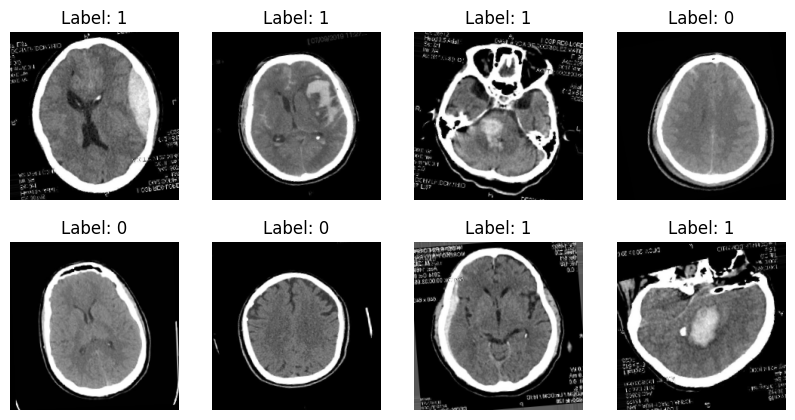

Image statistics:
Mean pixel value: 0.2458
Standard deviation: 0.3136
Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8015 - loss: 0.4394

101/101 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.8019 - loss: 0.4386 - val_accuracy: 0.9167 - val_loss: 0.2077
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9147 - loss: 0.1999

101/101 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.9148 - loss: 0.1999 - val_accuracy: 0.9470 - val_loss: 0.1277
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9415 - loss: 0.1677

101/101 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.9414 - loss: 0.1677 - val_accuracy: 0.9481 - val_loss: 0.1158
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9410 - loss: 0.1498

101/101 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.9410 - loss: 0.1498 - val_accuracy: 0.9502 - val_loss: 0.1069
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9495 - loss: 0.1339

101/101 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9495 - loss: 0.1339 - val_accuracy: 0.9632 - val_loss: 0.0930
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9590 - loss: 0.1144

101/101 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.9590 - loss: 0.1144 - val_accuracy: 0.9654 - val_loss: 0.0918
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9612 - loss: 0.1007 - val_accuracy: 0.9632 - val_loss: 0.0970
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9591 - loss: 0.1011

101/101 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9591 - loss: 0.1010 - val_accuracy: 0.9762 - val_loss: 0.0617
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.9667 - loss: 0.0784 - val_accuracy: 0.9762 - val_loss: 0.0605
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9699 - loss: 0.0824 - val_accuracy: 0.9719 - val_loss: 0.0684
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9691 - loss: 0.0613
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 642ms/step


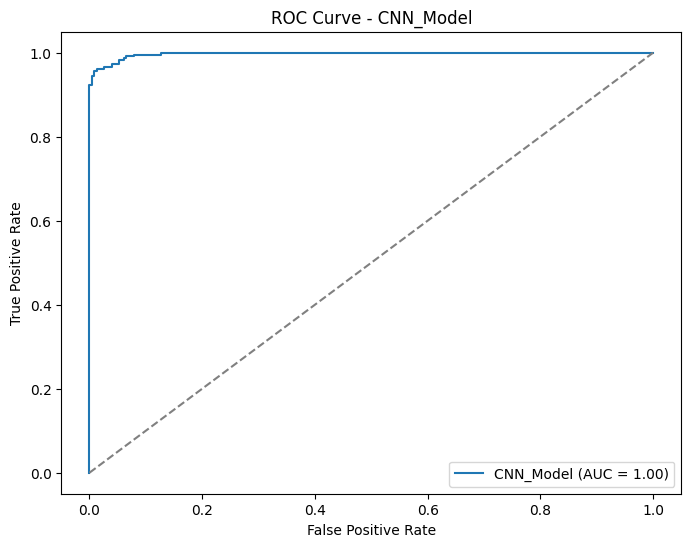

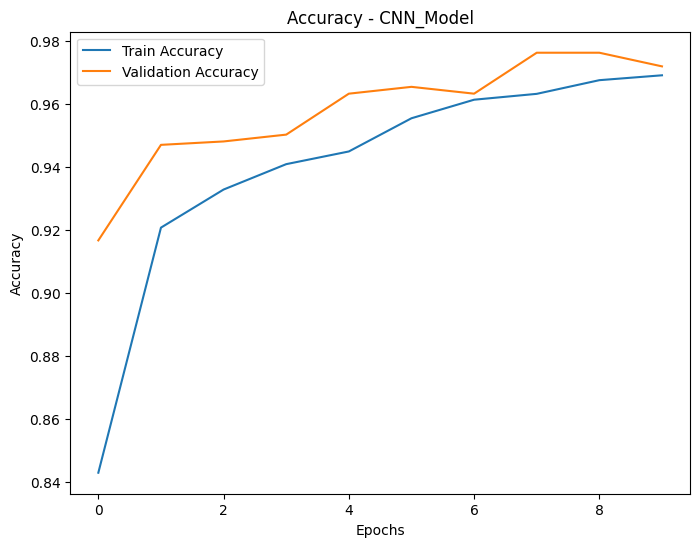

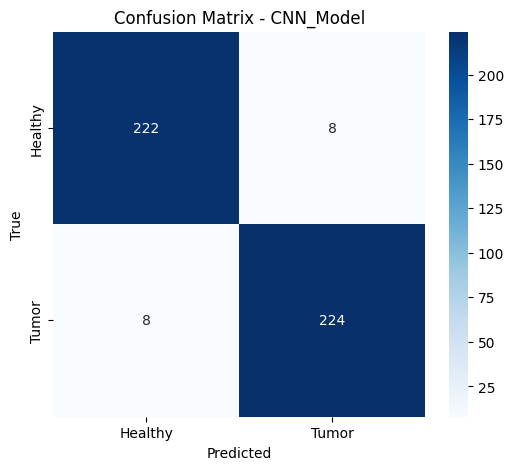

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6925 - loss: 0.5755 

101/101 ━━━━━━━━━━━━━━━━━━━━ 1764s 17s/step - accuracy: 0.6933 - loss: 0.5745 - val_accuracy: 0.8896 - val_loss: 0.3090
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8646 - loss: 0.3273 

101/101 ━━━━━━━━━━━━━━━━━━━━ 1559s 15s/step - accuracy: 0.8646 - loss: 0.3272 - val_accuracy: 0.9307 - val_loss: 0.2542
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 816s 8s/step - accuracy: 0.8748 - loss: 0.2994 - val_accuracy: 0.9221 - val_loss: 0.2188
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8930 - loss: 0.2752

101/101 ━━━━━━━━━━━━━━━━━━━━ 789s 8s/step - accuracy: 0.8931 - loss: 0.2751 - val_accuracy: 0.9470 - val_loss: 0.1871
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9080 - loss: 0.2395

101/101 ━━━━━━━━━━━━━━━━━━━━ 823s 8s/step - accuracy: 0.9081 - loss: 0.2395 - val_accuracy: 0.9481 - val_loss: 0.1780
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9329 - loss: 0.2090

101/101 ━━━━━━━━━━━━━━━━━━━━ 825s 8s/step - accuracy: 0.9327 - loss: 0.2091 - val_accuracy: 0.9502 - val_loss: 0.1624
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9197 - loss: 0.2197

101/101 ━━━━━━━━━━━━━━━━━━━━ 811s 8s/step - accuracy: 0.9197 - loss: 0.2197 - val_accuracy: 0.9513 - val_loss: 0.1487
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 817s 8s/step - accuracy: 0.9313 - loss: 0.1903 - val_accuracy: 0.9491 - val_loss: 0.1407
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 816s 8s/step - accuracy: 0.9277 - loss: 0.1961 - val_accuracy: 0.9513 - val_loss: 0.1405
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9314 - loss: 0.1937

101/101 ━━━━━━━━━━━━━━━━━━━━ 819s 8s/step - accuracy: 0.9314 - loss: 0.1937 - val_accuracy: 0.9556 - val_loss: 0.1299
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.9614 - loss: 0.1436
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step


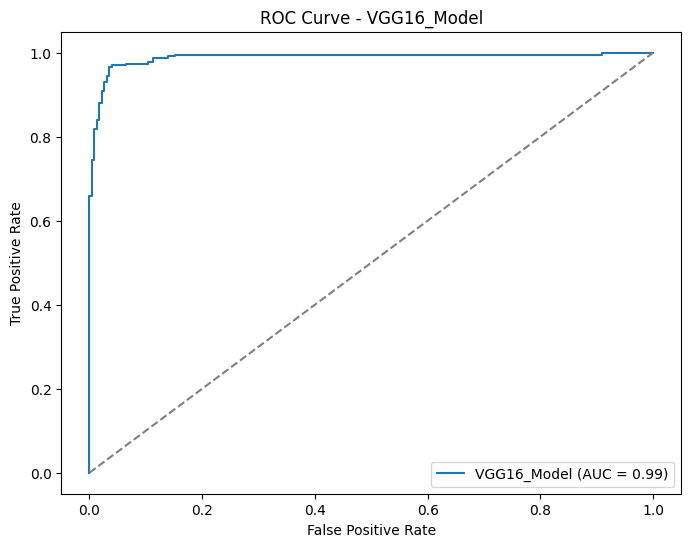

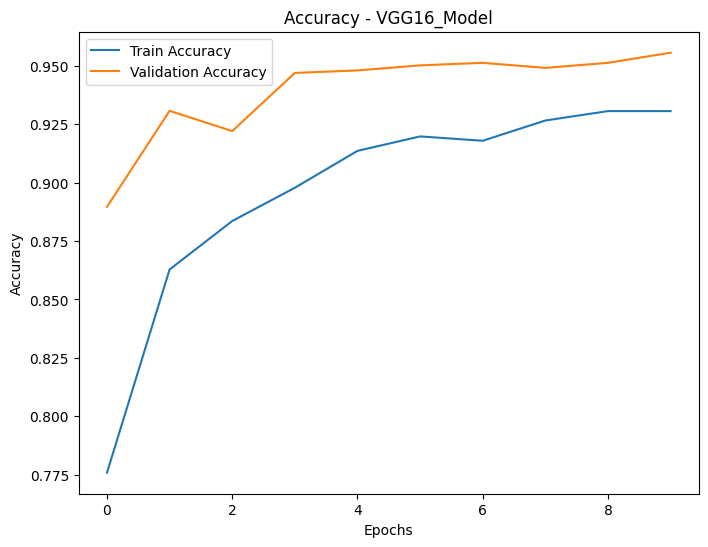

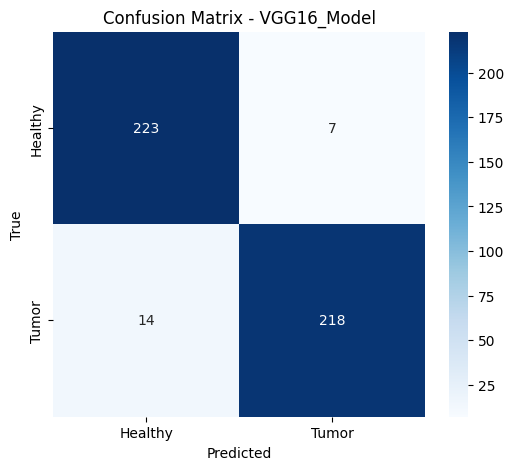

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6031 - loss: 0.6938

101/101 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.6038 - loss: 0.6931 - val_accuracy: 0.7413 - val_loss: 0.5338
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7349 - loss: 0.5259

101/101 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7350 - loss: 0.5258 - val_accuracy: 0.7608 - val_loss: 0.5032
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7623 - loss: 0.4987

101/101 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.7624 - loss: 0.4986 - val_accuracy: 0.8117 - val_loss: 0.4298
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7959 - loss: 0.4573

101/101 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7959 - loss: 0.4573 - val_accuracy: 0.8160 - val_loss: 0.4131
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7858 - loss: 0.4653

101/101 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.7858 - loss: 0.4652 - val_accuracy: 0.8258 - val_loss: 0.4036
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.8016 - loss: 0.4417 - val_accuracy: 0.8247 - val_loss: 0.3921
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8034 - loss: 0.4384

101/101 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.8034 - loss: 0.4383 - val_accuracy: 0.8377 - val_loss: 0.3811
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8222 - loss: 0.4073

101/101 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.8221 - loss: 0.4074 - val_accuracy: 0.8398 - val_loss: 0.3919
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.8167 - loss: 0.4174 - val_accuracy: 0.8366 - val_loss: 0.3681
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.8238 - loss: 0.4075 - val_accuracy: 0.8225 - val_loss: 0.3859
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9139 - loss: 0.2641
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step


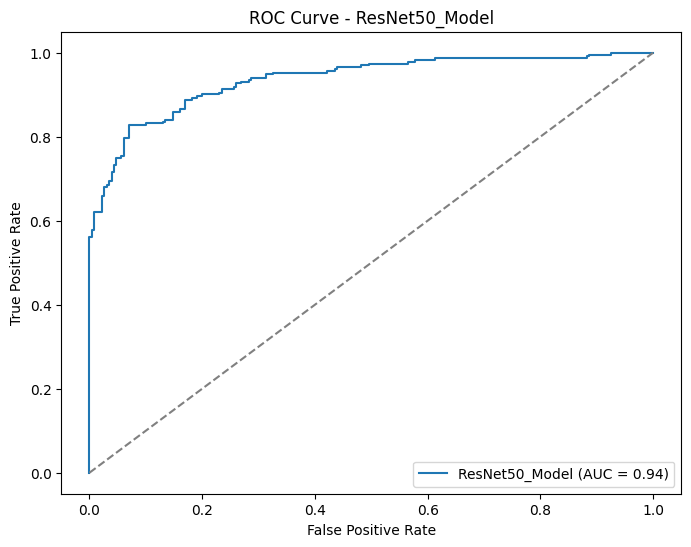

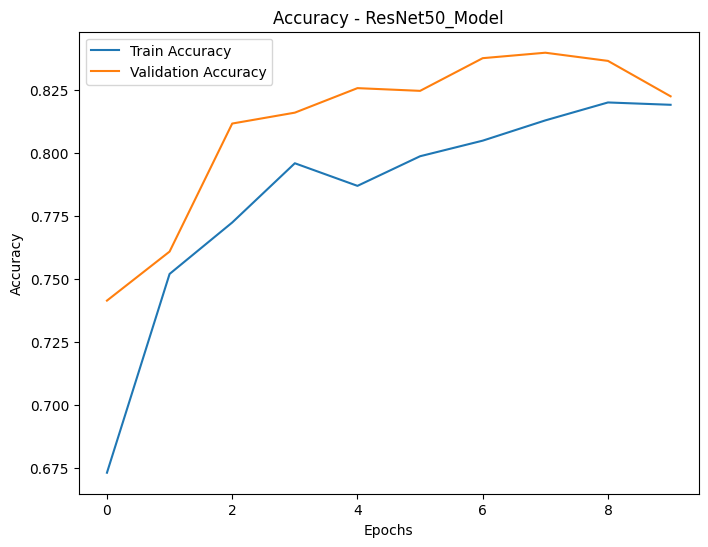

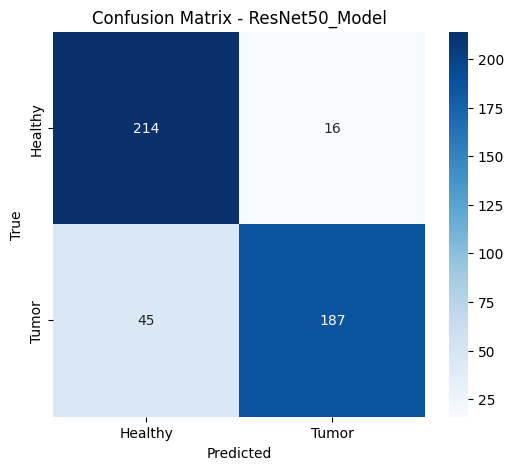

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7788 - loss: 0.4659

101/101 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.7794 - loss: 0.4647 - val_accuracy: 0.9307 - val_loss: 0.2063
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9071 - loss: 0.2405

101/101 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.9071 - loss: 0.2402 - val_accuracy: 0.9491 - val_loss: 0.1544
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9349 - loss: 0.1788 - val_accuracy: 0.9394 - val_loss: 0.1536
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9300 - loss: 0.1884 - val_accuracy: 0.9405 - val_loss: 0.1612
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9426 - loss: 0.1713

101/101 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9426 - loss: 0.1712 - val_accuracy: 0.9600 - val_loss: 0.1234
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9525 - loss: 0.1374 - val_accuracy: 0.9567 - val_loss: 0.1286
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9430 - loss: 0.1456 - val_accuracy: 0.9578 - val_loss: 0.1241
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9484 - loss: 0.1406 - val_accuracy: 0.9589 - val_loss: 0.1185
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9496 - loss: 0.1337

101/101 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9496 - loss: 0.1338 - val_accuracy: 0.9632 - val_loss: 0.1139
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9499 - loss: 0.1256 - val_accuracy: 0.9610 - val_loss: 0.1141
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9699 - loss: 0.0827
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step


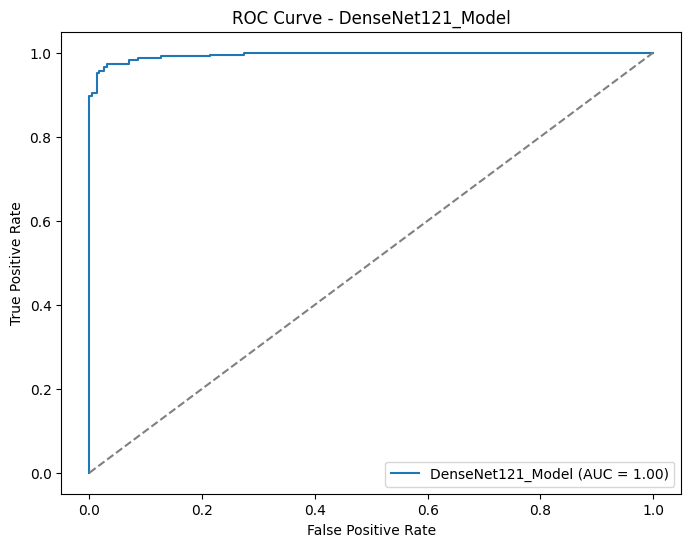

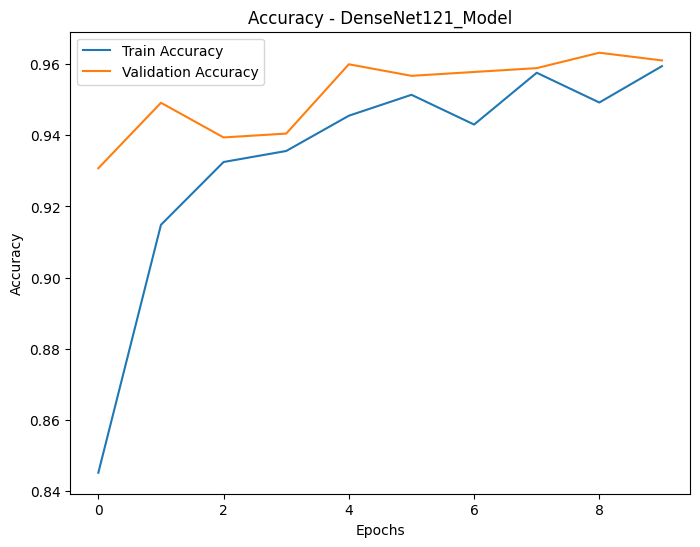

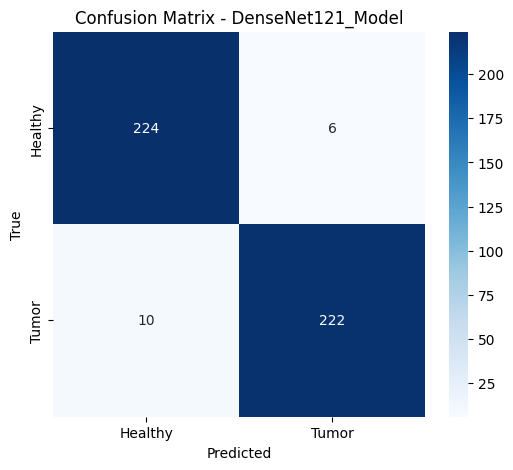

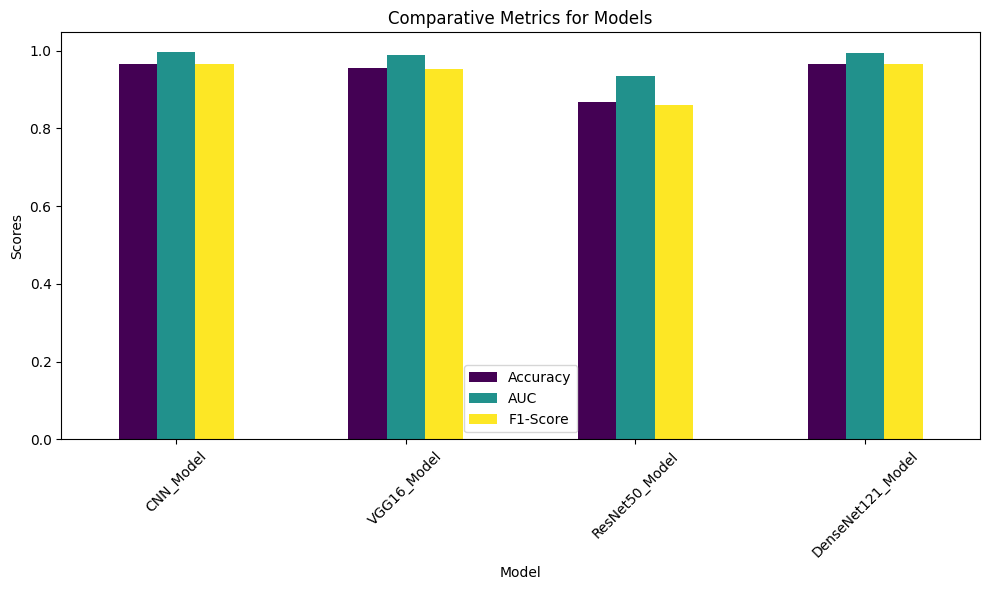

Best Model: CNN_Model


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil

# Paths and Parameters
dataset_path = "./CT/Brain Tumor CT scan Images"
train_dir = "./data01/train"
val_dir = "./data01/val"
test_dir = "./data01/test"
outcome_dir = "./outcome03"
image_size = (224, 224)
batch_size = 32
epochs = 10
random_seed = 42

# Ensure outcome directory exists
os.makedirs(outcome_dir, exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "plots"), exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "results"), exist_ok=True)


# Prepare Dataset with 10% Subset
def prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir, val_split=0.2, test_split=0.1):
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for label in ["Healthy", "Tumor"]:
        img_dir = os.path.join(dataset_path, label)
        images = os.listdir(img_dir)
        images = [os.path.join(img_dir, img) for img in images]

        # Select 10% of the data
        subset_images = np.random.choice(images, int(len(images) * 1), replace=False)

        train_images, temp_images = train_test_split(subset_images, test_size=(val_split + test_split), random_state=random_seed)
        val_images, test_images = train_test_split(temp_images, test_size=test_split / (val_split + test_split), random_state=random_seed)

        # Copy images to respective directories
        for img in train_images:
            dest = os.path.join(train_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in val_images:
            dest = os.path.join(val_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in test_images:
            dest = os.path.join(test_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

    print("Dataset (100%) prepared successfully!")
    
# Data Generators
def create_generators(train_dir, val_dir, test_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, horizontal_flip=True, rotation_range=15)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
    )

    return train_generator, val_generator, test_generator

# Build CNN Model
def build_cnn_model(input_shape, dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build Pre-trained Models
def build_pretrained_model(base_model, input_shape, dropout_rate=0.5):
    base_model = base_model(include_top=False, weights="imagenet", input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Comparative metrics storage
metrics_summary = []

# Train and Evaluate Model
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(os.path.join(outcome_dir, "models", f"{model_name}.keras"), monitor="val_accuracy", save_best_only=True, mode="max")
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Evaluate on Test Data
    test_loss, test_accuracy = model.evaluate(test_generator)

    # Predictions for AUC and Metrics
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

    # Save classification report
    report = classification_report(y_true, (y_pred > 0.5).astype(int), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(outcome_dir, "results", f"{model_name}_classification_report.csv"))

    # Add results to summary
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": test_accuracy,
        "AUC": roc_auc,
        "F1-Score": f1
    })

    # Save and Plot Metrics
    plot_metrics(model_name, history, fpr, tpr, roc_auc, y_true, y_pred)

    return test_accuracy

def plot_metrics(model_name, history, fpr, tpr, roc_auc, y_true, y_pred):
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_ROC.png"))
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_Accuracy.png"))
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Tumor"], yticklabels=["Healthy", "Tumor"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_Confusion_Matrix.png"))
    plt.show()

# Compare Models and Save Best
def compare_and_save_best():
    metrics_df = pd.DataFrame(metrics_summary)
    metrics_df.to_csv(os.path.join(outcome_dir, "results", "metrics_summary.csv"), index=False)

    # Plot Comparative Metrics
    metrics_df.set_index("Model", inplace=True)
    metrics_df[["Accuracy", "AUC", "F1-Score"]].plot(kind="bar", figsize=(10, 6), colormap="viridis")
    plt.title("Comparative Metrics for Models")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(outcome_dir, "plots", "Comparative_Metrics.png"))
    plt.show()

    # Select Best Model
    best_model_row = metrics_df[metrics_df["Accuracy"] == metrics_df["Accuracy"].max()]
    best_model_name = best_model_row.index[0]
    print(f"Best Model: {best_model_name}")
    return best_model_name

# Visualize Images and Statistics
def visualize_data(generator):
    sample_images, sample_labels = next(generator)
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Label: {int(sample_labels[i])}")
        plt.axis("off")
    plt.savefig(os.path.join(outcome_dir, "plots", "Sample_Images.png"))
    plt.show()
    plt.close()

    print("Image statistics:")
    print(f"Mean pixel value: {np.mean(sample_images):.4f}")
    print(f"Standard deviation: {np.std(sample_images):.4f}")

# Main Execution
if __name__ == "__main__":
    prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir)
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir, image_size, batch_size)

    input_shape = image_size + (3,)

    # Visualize Images and Statistics
    visualize_data(train_gen)    

    # Build and Train Models
    cnn_model = build_cnn_model(input_shape)
    cnn_accuracy = train_and_evaluate_model(cnn_model, train_gen, val_gen, test_gen, "CNN_Model")

    vgg16_model = build_pretrained_model(VGG16, input_shape)
    vgg16_accuracy = train_and_evaluate_model(vgg16_model, train_gen, val_gen, test_gen, "VGG16_Model")

    resnet_model = build_pretrained_model(ResNet50, input_shape)
    resnet_accuracy = train_and_evaluate_model(resnet_model, train_gen, val_gen, test_gen, "ResNet50_Model")

    densenet_model = build_pretrained_model(DenseNet121, input_shape)
    densenet_accuracy = train_and_evaluate_model(densenet_model, train_gen, val_gen, test_gen, "DenseNet121_Model")

    # Compare Models and Save Best
    best_model_name = compare_and_save_best()
